In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0'
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from learnMSA.msa_hmm import (Align, Clustering, Configuration, Initializers,
                              Visualize)
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset

2025-05-09 14:07:54.906962: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-09 14:07:54.922951: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-09 14:07:54.928045: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1746792476.069408  827828 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1746792476.110971  827828 cuda_executor.cc:1015] succ

### Ungapped alignment

In [2]:
name = "3_200"
suffix = "_short"

# unaligned sequences
train_filename = f"../trees/data/dev_msa/{name}{suffix}.unaligned.fa"
# reference alignment of all sequences
ref_filename = f"../trees/data/dev_msa/{name}{suffix}.fa"
# tree used to generate the sequences
tree_filename = f"../trees/data/dev_trees/{name}.nwk"

# number of distinct pHMMs
num_models = 1

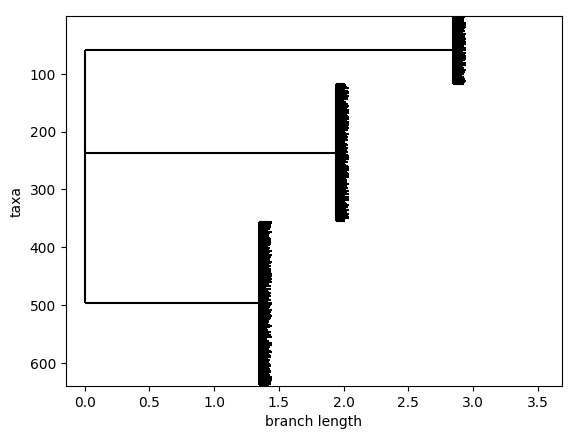

In [3]:
## Real tree used to generate the data
true_tree : Clustering.TreeHandler = Clustering.TreeHandler.read(tree_filename)
true_tree.draw(no_labels=True)

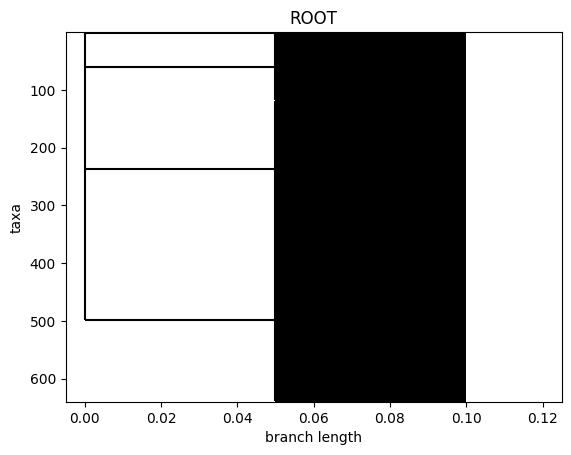

In [ ]:
# compute a clustering from the unaligned sequences and a rough initial tree 
# with short branches
clustering : pd.DataFrame = Clustering.compute_clustering(
    train_filename, cluster_seq_id=0.01, linear=False
)
tree_handler = Clustering.cluster_tree(clustering, branch_length=1.0)
tree_handler.draw(no_labels=True)

Falsely clustered sequences can lead to poor alignments. We'll have to account for that.

Problem: How to do that without computing emissions and transitions w.r.t. all models?

In [5]:
# compute cluster precision
true_cluster_indices = true_tree.get_parent_indices_by_height(0)
cluster_indices = tree_handler.get_parent_indices_by_height(0)

true_positives = 0
positives = 0   
trues = 0   

leaf_names = tree_handler.node_names[:tree_handler.num_leaves]
for i,u_name in enumerate(leaf_names):
    for v_name in leaf_names[i+1:]:
        u = tree_handler.nodes[u_name]
        v = tree_handler.nodes[v_name]
        tu = true_tree.nodes[u_name]
        tv = true_tree.nodes[v_name]
        positives += int(u.parent == v.parent)
        trues += int(tu.parent == tv.parent)
        true_positives += int(u.parent == v.parent and tu.parent == tv.parent)

print("Cluster precision:", true_positives/positives)
print("Cluster recall:", true_positives/trues)
print("True number of clusters: ", true_tree.num_anc-1)
print("Predicted number of clusters: ", tree_handler.num_anc-1)

Cluster precision: 1.0
Cluster recall: 0.9962354506152311
True number of clusters:  3
Predicted number of clusters:  4


In [6]:
out_filename = "test/data/star_independent_clusters.fasta"

In [7]:

with SequenceDataset(train_filename, fmt="fasta") as data:
    config = Configuration.make_default(
        num_models, 
        tree_handler=tree_handler,
        tree_loss_weight=0.0, #independent clusters, no tree loss
        use_tree_transitioner=True,
        propagate_root=False
    )
    initial_model_length_callback = partial(
        Align.get_initial_model_lengths, random=False
    )

    alignment_model = Align.run_learnMSA(
        data,
        out_filename,
        config, 
        verbose=True,
        align_insertions=True,
        initial_model_length_callback=initial_model_length_callback,
        A2M_output=False
    )

Training of 1 models on file 3_200_short.unaligned.fa
Configuration: 
{
num_models : 1
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alp

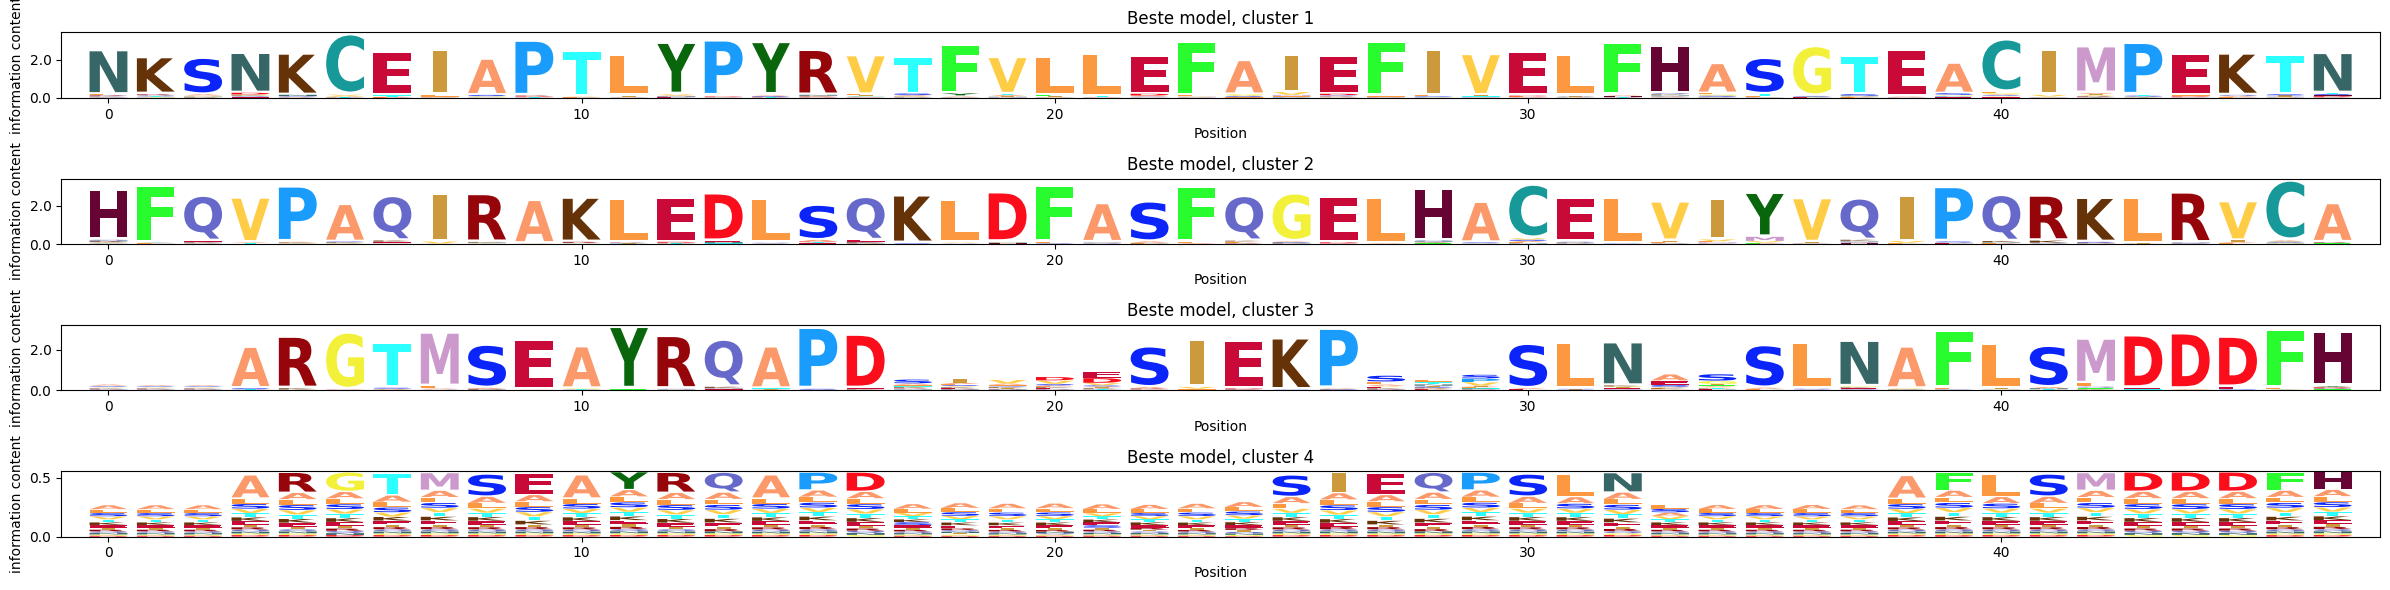

In [8]:
num_clust = tree_handler.num_anc-1
fig, axes = plt.subplots(num_clust, 1, figsize=(10, 5))
for i in range(num_clust):
    ax = axes[i]
    ax.set_title(f"Beste model, cluster {i+1}")
    ax.set_xlabel("Position")
    ax.set_ylabel("Information content")
    Visualize.plot_logo(
        alignment_model, alignment_model.best_model, ax, cluster_index=i
    )
plt.tight_layout()

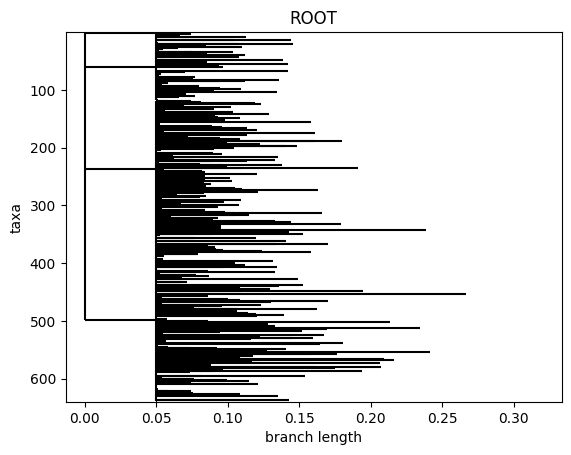

In [9]:
# plot the tree after training
# this requires to get both the branch lengths of the tree emitter for the 
# ancestral past of the tree as well as the lengths of all leaf branches from 
# the ancestral probability layer

# ancestral part
tree_emitter = alignment_model.msa_hmm_layer.cell.emitter[0]
branch_lengths = tree_emitter.get_branch_lengths().numpy()
branch_lengths = branch_lengths[:, alignment_model.best_model]
branch_lengths = branch_lengths[:, np.newaxis]

# leaf part
anc_prob_layer = alignment_model.encoder_model.layers[-3]
leaf_branch_lengths = anc_prob_layer.make_times().numpy()
leaf_branch_lengths = leaf_branch_lengths[:,alignment_model.best_model]
leaf_branch_lengths = leaf_branch_lengths[:,np.newaxis]

branch_lengths = np.concatenate((leaf_branch_lengths, branch_lengths), axis=0)

tree_emitter.tree_handler.set_branch_lengths(branch_lengths)
tree_emitter.tree_handler.draw(no_labels=True)

In [12]:
fastsp_bin = "../snakeMSA/FastSP/FastSP.jar"
!java -jar {fastsp_bin} -r {ref_filename} -e test/data/star_independent_clusters.fasta

Reference alignment: /home/felix/src/learnMSA/../trees/data/dev_msa/3_200_short.fa ...
Estimated alignment: /home/felix/src/learnMSA/test/data/star_independent_clusters.fasta ...
MaxLenNoGap= 73, NumSeq= 639, LenRef= 806, LenEst= 188, Cells= 635166
computing ...
Number of shared homologies: 2962943
Number of homologies in the reference alignment: 6290703
Number of homologies in the estimated alignment: 7458071
Number of correctly aligned columns: 0
Number of aligned columns in ref. alignment: 83
Number of singleton and (uncollapsed) insertion columns in ref. alignment: 669 0
Number of aligned columns in est. alignment: 139
Number of singleton and (uncollapsed) insertion columns in est. alignment: 49 0
SP-Score 0.47100347926137986
Modeler 0.39728007416394934
SPFN 0.5289965207386201
SPFP 0.6027199258360507
Compression (naive) 0.23325062034739455
Compression 0.25
TC 0.0
Time to compute (seconds): 0.057


In [11]:
#compute the cluster SP-scores
cluster_ids = tree_handler.get_parent_indices_by_height(0)-tree_handler.num_leaves
num_clust = np.max(cluster_ids)+1

cluster_ref_seqs = []
cluster_pred_seqs = []
for j in range(num_clust):
    cluster_ref_seqs.append([])
    cluster_pred_seqs.append([])

ref_data = SequenceDataset(ref_filename)
pred_data = SequenceDataset(out_filename)

for i,j in enumerate(cluster_ids):
    ref_seq = ref_data.get_standardized_seq(i, remove_gaps=False)
    pred_seq = pred_data.get_standardized_seq(i, remove_gaps=False)
    header = ref_data.get_header(i)
    assert header == pred_data.get_header(i)
    cluster_ref_seqs[j].append((header, ref_seq))
    cluster_pred_seqs[j].append((header, pred_seq))

ref_data.close()
pred_data.close()

for j in range(num_clust):

    cluster_ref_file_name = f"tmp/{j}_ref"
    with open(cluster_ref_file_name, "w") as cluster_ref_file:
        for header, seq in cluster_ref_seqs[j]:
            cluster_ref_file.write(">"+header+"\n")
            cluster_ref_file.write(seq+"\n")

    cluster_pred_file_name = f"tmp/{j}_pred"
    with open(cluster_pred_file_name, "w") as cluster_pred_file:
        for header, seq in cluster_pred_seqs[j]:
            cluster_pred_file.write(">"+header+"\n")
            cluster_pred_file.write(seq+"\n")

    print("Cluster", j)
    print("Size: ", len(cluster_pred_seqs[j]))
    !java -jar {fastsp_bin} -r {cluster_ref_file_name} -e {cluster_pred_file_name}

Cluster 0
Size:  117
Reference alignment: /home/felix/src/learnMSA/tmp/0_ref ...
Estimated alignment: /home/felix/src/learnMSA/tmp/0_pred ...
MaxLenNoGap= 68, NumSeq= 117, LenRef= 806, LenEst= 188, Cells= 116298
computing ...
Number of shared homologies: 316800
Number of homologies in the reference alignment: 322893
Number of homologies in the estimated alignment: 323521
Number of correctly aligned columns: 19
Number of aligned columns in ref. alignment: 50
Number of singleton and (uncollapsed) insertion columns in ref. alignment: 161 0
Number of aligned columns in est. alignment: 89
Number of singleton and (uncollapsed) insertion columns in est. alignment: 48 0
SP-Score 0.9811299718482593
Modeler 0.9792254598619564
SPFN 0.01887002815174066
SPFP 0.020774540138043585
Compression (naive) 0.23325062034739455
Compression 0.6492890995260664
TC 0.38
Time to compute (seconds): 0.025
Cluster 1
Size:  238
Reference alignment: /home/felix/src/learnMSA/tmp/1_ref ...
Estimated alignment: /home/fel